In [1]:
from molmap import model as molmodel
import molmap
from molmap import dataset
import matplotlib.pyplot as plt

import pandas as pd
from tqdm import tqdm
from joblib import load, dump
tqdm.pandas(ascii=True)
import numpy as np

import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

seed = 123
np.random.seed(seed)
tf.compat.v1.set_random_seed(seed)

/home/sxh/anaconda3/envs/my-rdkit-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sxh/anaconda3/envs/my-rdkit-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sxh/anaconda3/envs/my-rdkit-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sxh/anaconda3/envs/my-rdkit-env

In [2]:
df_train = pd.read_csv('../train.csv', index_col = 0)
df_valid = pd.read_csv('../valid.csv',  index_col = 0)
df_test = pd.read_csv('../test.csv',  index_col = 0)
df_etc = pd.read_csv('../etc.csv')
task = 'measured log solubility in mols per litre'
df_etc[task] = df_etc.Exp_LogS

In [3]:
df = df_train.append(df_valid).append(df_test).append(df_etc)
df = df.reset_index(drop=True)

train_idx = df.index[:len(df_train)]
valid_idx = df.index[len(df_train): len(df_train)+len(df_valid)]
test_idx = df.index[len(df_train)+len(df_valid): len(df_train)+len(df_valid) + len(df_test)]
etc_idx = df.index[-len(df_etc):]
len(train_idx), len(valid_idx), len(test_idx), len(etc_idx)

/home/sxh/anaconda3/envs/my-rdkit-env/lib/python3.6/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


(901, 113, 113, 120)

## load optimized molmaps

In [4]:
### optimized hyper-parameters
n_neighbors = 30
min_dist = 0.25

task_name = 'solubility'
tmp_feature_dir = './tmpignore'
if not os.path.exists(tmp_feature_dir):
    os.makedirs(tmp_feature_dir)
    
opt_mp = './optimized_descriptor.mp'
if not os.path.exists(opt_mp):
    mp1 = molmap.loadmap('../../descriptor.mp')
    mp1.fit(method = 'umap', min_dist = min_dist, n_neighbors = n_neighbors)
    mp1.save(opt_mp)
else:
    mp1 = molmap.loadmap(opt_mp)

In [5]:
_ = mp1.plot_grid('./result/')
_ = mp1.plot_scatter('./result/')

2020-01-29 12:46:33,111 - INFO - [bidd-molmap] - generate file: ./result/descriptor_1344_cosine_umap_molmap
2020-01-29 12:46:33,158 - INFO - [bidd-molmap] - save html file to ./result/descriptor_1344_cosine_umap_molmap
2020-01-29 12:46:33,159 - INFO - [bidd-molmap] - generate file: ./result/descriptor_1344_cosine_umap_scatter
2020-01-29 12:46:33,202 - INFO - [bidd-molmap] - save html file to ./result/descriptor_1344_cosine_umap_scatter


In [6]:
X1_name = os.path.join(tmp_feature_dir, 'X1_optimized_%s.data' % task_name)
if not os.path.exists(X1_name):
    X1 = mp1.batch_transform(df.smiles, n_jobs = 8)
    dump(X1, X1_name)
else:
    X1 = load(X1_name)

In [7]:
Y = df[[task]].values

trainX = X1[train_idx]
trainY = Y[train_idx]

validX = X1[valid_idx]
validY = Y[valid_idx]

testX = X1[test_idx]
testY = Y[test_idx]

etcX = X1[etc_idx]
etcY = Y[etc_idx]

In [8]:
epochs = 500
patience = 50 # early stopping
dense_layers = [128, 32]
batch_size = 128
lr = 1e-4
weight_decay = 0

loss = 'mse'
monitor = 'val_loss'
dense_avf = 'tanh'
last_avf = 'linear'

In [9]:

model = molmodel.net.SinglePathNet(X1.shape[1:], 
                                   n_outputs=Y.shape[-1], 
                                   dense_layers=dense_layers, 
                                   dense_avf = dense_avf, 
                                   last_avf=last_avf)

opt = tf.keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) #
#import tensorflow_addons as tfa
#opt = tfa.optimizers.AdamW(weight_decay = 0.1,learning_rate=0.001,beta1=0.9,beta2=0.999, epsilon=1e-08)
model.compile(optimizer = opt, loss = loss)
performance = molmodel.cbks.Reg_EarlyStoppingAndPerformance((trainX, trainY), 
                                                           (validX, validY), 
                                                           patience = patience, 
                                                           criteria = monitor)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [10]:
model.fit(trainX, trainY, batch_size=batch_size, 
          epochs=epochs, verbose= 0, shuffle = True, 
          validation_data = (validX, validY), 
          callbacks=[performance]) 

epoch: 0001, loss: 8.4615 - val_loss: 5.0994; rmse: 2.2570 - rmse_val: 2.2582;  r2: 0.3602 - r2_val: 0.3125                                                                                                    
epoch: 0002, loss: 4.6931 - val_loss: 4.1187; rmse: 2.1186 - rmse_val: 2.0295;  r2: 0.4566 - r2_val: 0.4256                                                                                                    
epoch: 0003, loss: 4.5422 - val_loss: 4.1154; rmse: 2.1296 - rmse_val: 2.0286;  r2: 0.5236 - r2_val: 0.5023                                                                                                    
epoch: 0004, loss: 4.4839 - val_loss: 4.1124; rmse: 2.1000 - rmse_val: 2.0279;  r2: 0.5751 - r2_val: 0.5541                                                                                                    
epoch: 0005, loss: 4.4081 - val_loss: 4.1378; rmse: 2.0953 - rmse_val: 2.0342;  r2: 0.5897 - r2_val: 0.5646                                                             

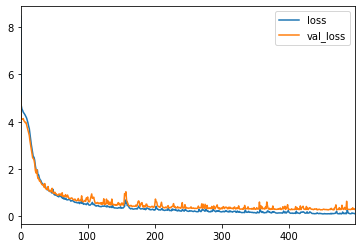

In [11]:
dfp = pd.DataFrame(performance.history)[['loss', 'val_loss']]
dfp.plot()

In [12]:
performance.evaluate(trainX, trainY) # RMSE, R^2

([0.34322864183044044], [0.9761979552989887])

In [13]:
performance.evaluate(validX, validY) # RMSE, R^2

([0.5255324109506085], [0.9338405820350548])

In [14]:
performance.evaluate(testX, testY) # RMSE, R^2

([0.47124981093442814], [0.9446133616364221])

In [15]:
performance.evaluate(etcX, etcY)  # RMSE, R^2

([0.8558881695898682], [0.48035115571524106])

In [16]:
dfr = df_etc[['Exp_LogS']].join(pd.DataFrame(performance.model.predict(etcX), columns= ['Pred_LogS']))
dfr.corr()

,Exp_LogS,Pred_LogS
Exp_LogS,1.000000,0.693074
Pred_LogS,0.693074,1.000000


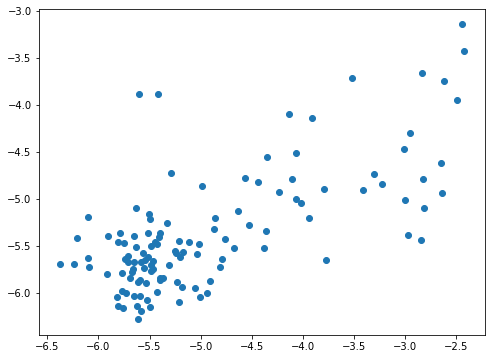

In [17]:
plt.figure(figsize = (8,6))
plt.scatter(dfr.Exp_LogS, dfr.Pred_LogS)

In [18]:
#performance.model.save('solubility_MMND.h5')